# Titanic Kaggle Competition

This is the notebook of Eric Massip and Hanna Figini used for applying to the Titanic Kaggle Competition. Some of the data preprocessing and feature extraction ideas have been developed thanks to the following articles: https://medium.com/i-like-big-data-and-i-cannot-lie/how-i-scored-in-the-top-9-of-kaggles-titanic-machine-learning-challenge-243b5f45c8e9 & https://www.kaggle.com/goldens/titanic-on-the-top-with-a-simple-model.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, chi2

## Raw Extraction

In [291]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")
titanic=pd.concat([train_data, test_data], sort=False)
train_idx = train_data.shape[0]
test_idx = titanic.shape[0] - test_data.shape[0]

In [292]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data preprocessing

In [293]:
print('Instances = ' + str(titanic.shape[0]))
titanic.isna().sum()

Instances = 1309


PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

There is only one Fare value missing and it corresponds to a passenger of Pclass = 3, so we calculate the average Fare for the passengers of Pclass = 3.

In [294]:
titanic['Fare'] = titanic['Fare'].fillna(titanic.loc[titanic.Pclass == 3, 'Fare'].mean())

For the missing Embarked, we set them to the most frequent value.

In [295]:
titanic['Embarked'] = titanic['Embarked'].fillna(titanic['Embarked'].mode().values[0])

There are a lot of missing cabins, but we planned a strategy to impute feasible values. We extract the first letter of each cabin if it exists. If it doesn't, we use the letter that corresponds to the cabins' mode of each Pclass.

In [296]:
titanic.Cabin = titanic.Cabin.map(lambda x: x[0] if not pd.isna(x) else np.nan)
titanic.Cabin = titanic.apply(lambda x: titanic[titanic.Pclass == x['Pclass']]['Cabin'].mode() if pd.isna(x['Cabin']) else x['Cabin'], axis=1)
list(titanic.Cabin.unique())

['F', 'C', 'E', 'G', 'D', 'A', 'B', 'T']

## Feature Extraction

The SibSp and Parch columns don't seem to mean much on their own, so we aggreggate them into one single column called FamilySize. 

In [297]:
titanic['FamilySize'] = titanic.Parch + titanic.SibSp + 1

There are many titles based on the position, age or status of each passenger. Following the ideas of https://medium.com/i-like-big-data-and-i-cannot-lie/how-i-scored-in-the-top-9-of-kaggles-titanic-machine-learning-challenge-243b5f45c8e9, we have reduced the amount of titles by aggreggating some of them. This will help us to extrapolate the missing values for the Age column.

In [298]:
newtitles={
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"}

titanic['Title'] = titanic.apply(lambda x: x['Name'].split(',')[1].split('.')[0].strip(), axis=1)
titanic['Title']=titanic.Title.map(newtitles)
list(titanic.Title.unique())

['Mr', 'Mrs', 'Miss', 'Master', 'Royalty', 'Officer']

Thanks to the new Title column, we can group by the Sex, Pclass and Title, and get a closer approximation to the actual value of the missing Age values.

In [299]:
grouped = titanic.groupby(['Sex','Pclass', 'Title'])
gf = grouped.Age.mean().reset_index()
gf

,Sex,Pclass,Title,Age
0,female,1,Miss,30.131148
1,female,1,Mrs,42.926471
2,female,1,Officer,49.000000
3,female,1,Royalty,40.000000
4,female,2,Miss,20.717083
5,female,2,Mrs,33.418182
6,female,3,Miss,17.360874
7,female,3,Mrs,32.326531
8,male,1,Master,6.984000
9,male,1,Mr,41.450758


In [300]:
def get_new_age(row):
    if pd.isna(row['Age']):
        return gf[(gf.Sex == row['Sex']) & 
                  (gf.Pclass == row['Pclass']) & 
                  (gf.Title == row['Title'])].Age.values[0]
    else:
        return row['Age']

titanic.Age=titanic.apply(lambda x: get_new_age(x), axis=1)

We convert the Sex column to a binary 0/1.

In [301]:
titanic['Sex'] = titanic.apply(lambda x: int(x['Sex'] == 'male'), axis=1)

In [302]:
list(titanic.columns)

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked',
 'FamilySize',
 'Title']

In [303]:
titanic.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket'], axis=1, inplace=True)

In [304]:
titanic_dummies = pd.get_dummies(titanic)

train = titanic_dummies[:train_idx].copy()
test = titanic_dummies[test_idx:].copy()

train.Survived = train.Survived.astype(int)

df = train
df_test = test.drop(['Survived'], axis=1)

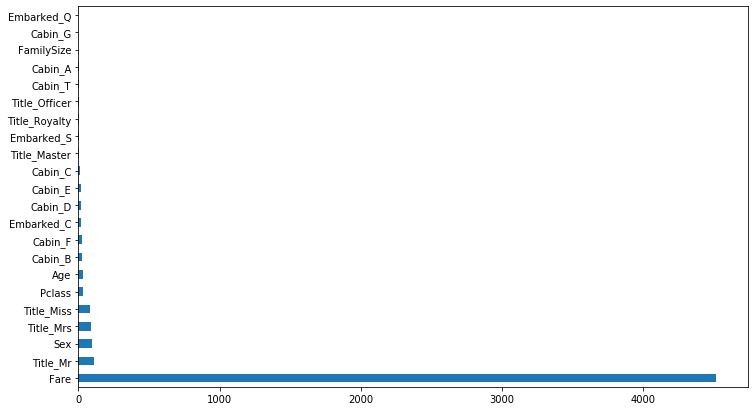

In [305]:
bestfeatures = SelectKBest(score_func=chi2, k='all')
model = bestfeatures.fit(df.drop(['Survived'], axis=1).values, df['Survived'].values)
scores = model.scores_

fig, _ = plt.subplots(figsize=(12,7))
pd.Series(scores, index=df.drop(['Survived'], axis=1).columns).nlargest(30).plot(kind='barh')

## Modeling

In [306]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

x = df.drop(['Survived'], axis=1).values
y = df['Survived'].values

print('Random Forest Classifier')
parameters = dict(     
    max_depth = [n for n in range(9, 14)],     
    min_samples_split = [n for n in range(4, 11)], 
    min_samples_leaf = [n for n in range(2, 5)],     
    n_estimators = [n for n in range(10, 60, 10)],
)
cv_rf = GridSearchCV(RandomForestClassifier(), parameters, scoring='accuracy', cv=5).fit(x, y)
print("Accuracy: %0.2f" % (cv_rf.best_score_))
print(f'Best params: {cv_rf.best_params_}')

print()

print('SVM RBF')
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('svm_rbf', SVC(kernel='rbf'))])
parameters = {'svm_rbf__C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10], 'svm_rbf__gamma': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}
cv_svm = GridSearchCV(pipeline, parameters, scoring='accuracy', cv=5).fit(x, y)
print("Accuracy: %0.2f" % (cv_svm.best_score_))
print(f'Best params: {cv_svm.best_params_}')

Random Forest Classifier
Accuracy: 0.84
Best params: {'max_depth': 13, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 40}

SVM RBF
Accuracy: 0.83
Best params: {'svm_rbf__C': 1, 'svm_rbf__gamma': 0.1}


In [290]:
predictions = cv_svm.predict(df_test.values)

output = pd.DataFrame({'PassengerId': pd.read_csv("data/test.csv").PassengerId, 'Survived': predictions})
output.to_csv('data/my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
